In [1]:

import lancedb


In [2]:
def get_metadata_value(table, key_name, value_column="value"):
    """
    Retrieves a single value from a LanceDB table given a key.
    
    Args:
        table: The opened LanceDB table object.
        key_name: The string key to look for (e.g., 'tbl_img_emb').
        value_column: The name of the column containing the data.
    """
    # Filter for the key and select only the necessary column
    result = table.search().where(f"key='{key_name}'").select([value_column]).to_pandas()
    
    if not result.empty:
        return result[value_column].iloc[0]
    return None

In [3]:
# Path where your config DB lives
embedding_db_path = "/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/experiments/era5"
source_img_path= "/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/shared_source"
# Name of your config table
project_name = "dinov3"
src_img_tbl_name ="era5_sample_images"

# Connect and open table
db = lancedb.connect(embedding_db_path)
source_db= lancedb.connect(source_img_path)
config_tbl = db.open_table(project_name+"_config")
img_emb_tbl= db.open_table(get_metadata_value(config_tbl, "img_emb_table_current"))
patch_emb_tbl= db.open_table(get_metadata_value(config_tbl, "patch_emb_table_current"))
src_img_tbl= source_db.open_table(src_img_tbl_name)

# patch_emb_tbl.count_rows()

In [4]:
src_img_tbl.schema

# patch_emb_tbl= db.open_table(get_metadata_value(config_tbl, "patch_emb_table_current"))

id: string
filename: string
dt: timestamp[s]
image_blob: binary
thumb_blob: binary
-- schema metadata --
version: '1.0'
dataset_info: '{"dataset_name": "ERA5 Hurricane Training Data (RGB Compos' + 1339

In [5]:
patch_emb_tbl.schema

patch_id: string
image_id: string
patch_index: int32
embedding: fixed_size_list<item: float>[768]
  child 0, item: float

In [6]:
img_emb_tbl.schema

image_id: string
embedding: fixed_size_list<item: float>[768]
  child 0, item: float

In [7]:
config_tbl.schema

key: string
value: string

image size: (256, 256)
patch_index: 150


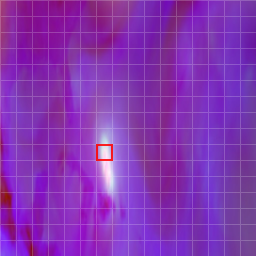

In [8]:
import io

from PIL import Image, ImageDraw

FILENAME  = "20170922_rgb.jpeg"  
PATCH_SIZE = 16
IMG_SIZE   = 256
DRAW_GRID  = True

def fetch_image_by_filename(src_img_tbl, filename: str):
    """Load image from src_img_tbl using filename instead of id."""
    row = (
        src_img_tbl.search()
        .where(f"filename = '{filename}'")
        .limit(1)
        .to_pandas()
        .iloc[0]
    )
    return Image.open(io.BytesIO(row["image_blob"])).convert("RGBA")

def overlay_grid(img: Image.Image, patch_size: int = PATCH_SIZE,
                 color=(255, 255, 255, 50), width: int = 1) -> Image.Image:
    w, h = img.size
    overlay = Image.new("RGBA", img.size, (0, 0, 0, 0))
    d = ImageDraw.Draw(overlay)

    for x in range(0, w + 1, patch_size):
        d.line([(x, 0), (x, h)], fill=color, width=width)
    for y in range(0, h + 1, patch_size):
        d.line([(0, y), (w, y)], fill=color, width=width)

    return Image.alpha_composite(img, overlay)

def patch_box_from_index(patch_index: int,
                         img_w: int = IMG_SIZE,
                         img_h: int = IMG_SIZE,
                         patch_size: int = PATCH_SIZE):

    grid_w = img_w // patch_size
    grid_h = img_h // patch_size
    n_patches = grid_w * grid_h

    if patch_index < 0 or patch_index >= n_patches:
        raise ValueError(f"patch_index {patch_index} out of range [0, {n_patches-1}]")

    row = patch_index // grid_w
    col = patch_index % grid_w

    x0 = col * patch_size
    y0 = row * patch_size
    x1 = x0 + patch_size
    y1 = y0 + patch_size
    return (x0, y0, x1, y1)

def highlight_patch(img: Image.Image, box,
                    fill=(255, 0, 0, 0),
                    outline=(255, 0, 0, 220),
                    outline_width: int = 2) -> Image.Image:

    overlay = Image.new("RGBA", img.size, (0, 0, 0, 0))
    d = ImageDraw.Draw(overlay)
    d.rectangle(box, fill=fill, outline=outline, width=outline_width)
    return Image.alpha_composite(img, overlay)



#  Load image by FILENAME (not id)
img = fetch_image_by_filename(src_img_tbl, FILENAME)
print("image size:", img.size)

# Optional sanity check
if img.size != (IMG_SIZE, IMG_SIZE):
    print(f"WARNING: expected {(IMG_SIZE, IMG_SIZE)} but got {img.size}")

# Create visualization image
img_vis = img
if DRAW_GRID:
    img_vis = overlay_grid(img_vis, PATCH_SIZE)

# Choose a patch to highlight
patch_index = 182 -16*2

print("patch_index:", patch_index)

# Highlight patch
box = patch_box_from_index(patch_index, IMG_SIZE, IMG_SIZE, PATCH_SIZE)
img_hl = highlight_patch(img_vis, box)
img_hl


In [9]:
image_id = (
    src_img_tbl.search()
    .where(f"filename = '{FILENAME}'")
    .select(["id"])
    .limit(1)
    .to_pandas()
    .iloc[0]["id"]
)

q = (
    patch_emb_tbl.search()
    .where(f"image_id = '{image_id}' AND patch_index = {patch_index}")
    .select(["patch_id", "image_id", "patch_index", "embedding"])
    .limit(1)
    .to_pandas()
    .iloc[0]
)

query_emb = q["embedding"]

top_df = (
    patch_emb_tbl.search(query_emb)
    .metric("cosine")
    .select(["patch_id", "image_id", "patch_index"])
    .limit(5000)
    .to_pandas()
)

top_df

[2026-01-21T20:15:43Z WARN  lance::dataset::scanner] Deprecation warning, this behavior will change in the future. This search specified output columns but did not include `_distance`.  Currently the `_distance` column will be included.  In the future it will not.  Call `disable_scoring_autoprojection` to to adopt the future behavior and avoid this warning


,patch_id,image_id,patch_index,_distance
0,9883bce29b3e75774bdaec6916559cf1:150,9883bce29b3e75774bdaec6916559cf1,150,88.793457
1,c6a2077329a2e511bad04c33e51ca567:97,c6a2077329a2e511bad04c33e51ca567,97,88.853302
2,42ccca6fc642a0dfe357d4cb5c1b58c6:193,42ccca6fc642a0dfe357d4cb5c1b58c6,193,88.933510
3,6346b95e52d23d036b8c4e8909304425:67,6346b95e52d23d036b8c4e8909304425,67,89.059723
4,9883bce29b3e75774bdaec6916559cf1:166,9883bce29b3e75774bdaec6916559cf1,166,89.175148
...,...,...,...,...
4995,2a47f1d5df8e411ea4d89108fdb99182:228,2a47f1d5df8e411ea4d89108fdb99182,228,93.547920
4996,d4c1338c0a729276a49c65d0cf35210a:166,d4c1338c0a729276a49c65d0cf35210a,166,93.547943
4997,22489ebcd05487b0bf1c7bf01c2c325e:89,22489ebcd05487b0bf1c7bf01c2c325e,89,93.548180
4998,371ed2d7df75904c3d5bc0203eb37c46:212,371ed2d7df75904c3d5bc0203eb37c46,212,93.548569


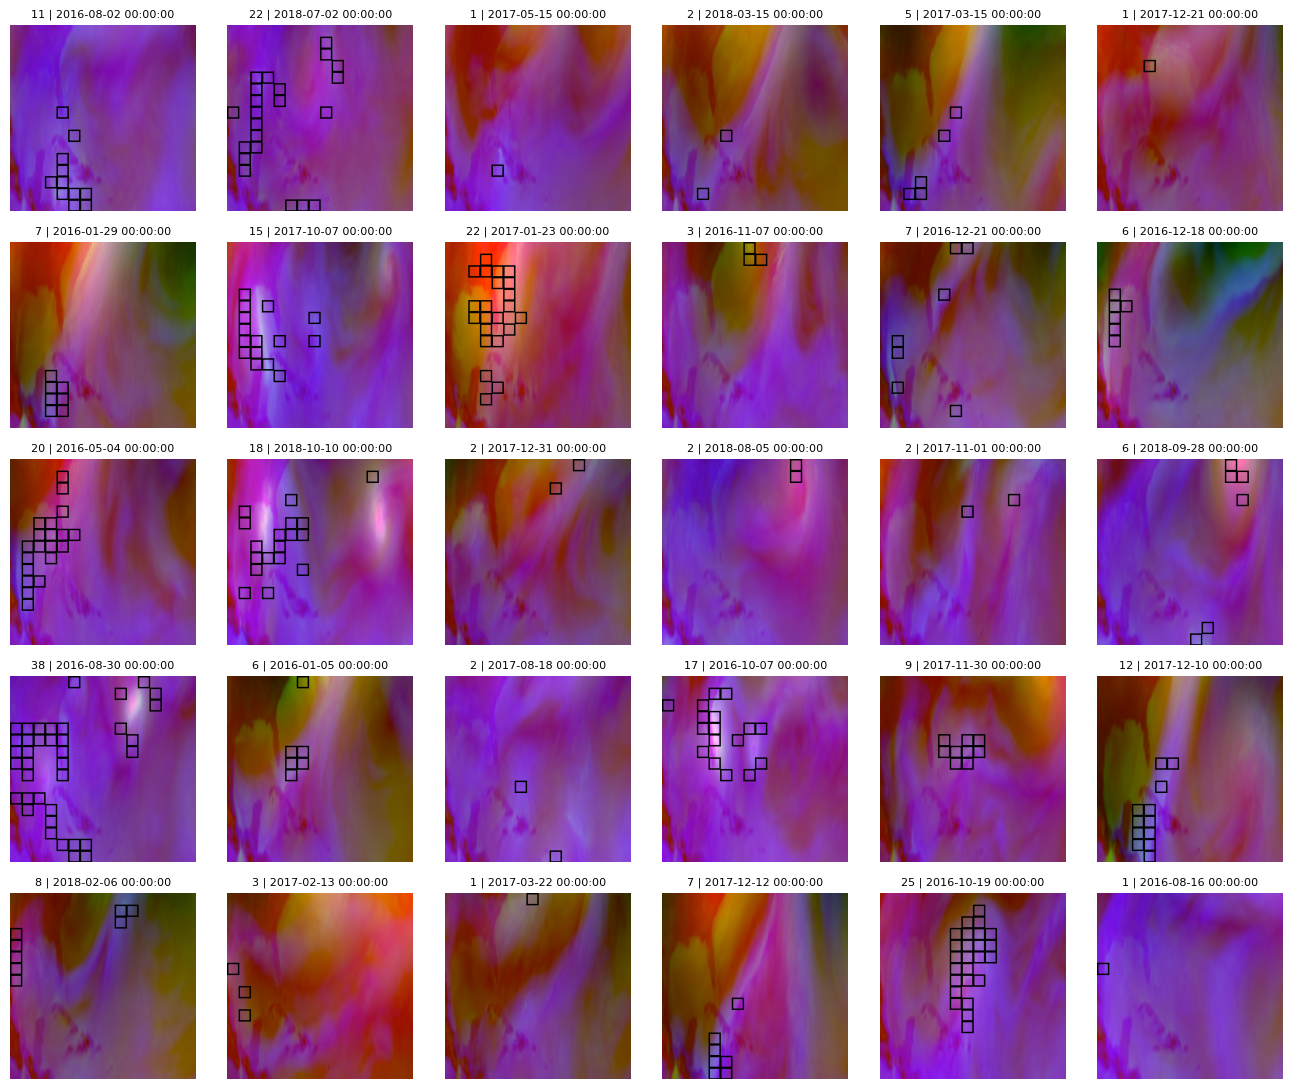

,image_id,dt,n_patches,patch_indices
0,011f1c83d35d5447f490724082412c5b,2016-08-02,11,"[212, 229, 228, 196, 230, 149, 211, 180, 246, ..."
1,018baaa08d856e244cdd63cd6bf81647,2018-07-02,22,"[66, 82, 98, 67, 24, 114, 146, 57, 246, 40, 13..."
2,01b32f1195561e0657659fe922349b3e,2017-05-15,1,[196]
3,01de727b76c183141fcb36307e780806,2018-03-15,2,"[227, 149]"
4,021237d9027593b5dc0db58e8ab830ef,2017-03-15,5,"[211, 226, 149, 118, 227]"
5,02785923616a10c61c26fb1c5a92b42d,2017-12-21,1,[52]
6,02fd8734680f7bfdaaebb0376b3881b7,2016-01-29,7,"[211, 227, 195, 179, 228, 212, 196]"
7,03993558decd759ab1639d98f643c623,2017-10-07,15,"[130, 83, 163, 146, 97, 81, 162, 113, 65, 132,..."
8,0409eb239c9b59233c0b694eca5b6f60,2017-01-23,22,"[132, 115, 99, 83, 117, 85, 98, 69, 102, 131, ..."
9,0417fbacb8ed14d9141408de8b1b96ef,2016-11-07,3,"[23, 7, 24]"


In [11]:
import math

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

PATCH, BASE = 16, 256

# group matches by image_id; keep up to 30 unique images
u = top_df.groupby("image_id")["patch_index"].apply(list).head(30)

thumbs, rows = [], []
for img_id, pidxs in u.items():
    r = (src_img_tbl.search()
         .where(f"id = '{img_id}'")
         .select(["image_blob","dt"])
         .limit(1).to_pandas().iloc[0])

    im = Image.open(io.BytesIO(r["image_blob"])).convert("RGB")
    tw, th = im.size
    sx, sy = tw / BASE, th / BASE
    grid_w = BASE // PATCH

    d = ImageDraw.Draw(im)
    for pidx in map(int, pidxs):
        rr, cc = pidx // grid_w, pidx % grid_w
        x0, y0 = cc * PATCH, rr * PATCH
        box = (int(x0*sx), int(y0*sy), int((x0+PATCH)*sx), int((y0+PATCH)*sy))
        d.rectangle(box, outline=(0, 0, 0), width=max(2, int(round(min(sx, sy)))))

    thumbs.append(im)
    rows.append({"image_id": img_id, "dt": r["dt"], "n_patches": len(pidxs), "patch_indices": pidxs})

dates_df = pd.DataFrame(rows)

n = len(thumbs)
cols = min(6, n)
rows_n = math.ceil(n / cols)
plt.figure(figsize=(cols*2.2, rows_n*2.2))
for i, im in enumerate(thumbs, 1):
    ax = plt.subplot(rows_n, cols, i)
    ax.imshow(im)
    ax.set_title(f'{dates_df.loc[i-1,"n_patches"]} | {str(dates_df.loc[i-1,"dt"])[:19]}', fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

dates_df
